# MERSCOPE Region R1 Analysis

This notebook performs an analysis of MERSCOPE data for region R1, focusing on data loading, exploratory data analysis (EDA), and visualization.

In [1]:
# Import necessary libraries
import scanpy as sc
import anndata as ad
import pandas as pd
import geopandas as gpd # For potential .parquet file with geometries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # For displaying images
import seaborn as sns
import numpy as np # For calculations if needed
import os
import squidpy
import warnings

# Suppress FutureWarning messages
warnings.filterwarnings('ignore', category=FutureWarning)

# Set plotting style
# plt.style.use('seaborn-v0_8-whitegrid')
# sc.settings.set_figure_params(dpi=100, frameon=True, figsize=(6, 6), facecolor='white')

## 1. Data Loading

We will prioritize loading the AnnData file (`.h5ad`) as it should contain the most comprehensive data. If needed, we will supplement with other files.

In [ ]:
# Define file paths
base_path = '../202503071102_SESSA-p30-E165_VMSC10702/R1'
h5ad_file = os.path.join(base_path, '202503071102_SESSA-p30-E165_VMSC10702_region_R1.h5ad')
cell_by_gene_file = os.path.join(base_path, 'cell_by_gene.csv')
cell_metadata_file = os.path.join(base_path, 'cell_metadata.csv')
differentially_expressed_genes_file = os.path.join(base_path, 'differentially_expressed_genes.csv')
# cell_categories_file = os.path.join(base_path, 'cell_categories.csv')
# cell_numeric_categories_file = os.path.join(base_path, 'cell_numeric_categories.csv')
cell_boundaries_file = os.path.join(base_path, 'cell_boundaries.parquet')
detected_transcripts_file = os.path.join(base_path, 'detected_transcripts.parquet')

summary_image_file = os.path.join(base_path, 'summary.png')

# Attempt to load the .h5ad file
adata = None
try:
    adata = sc.read_h5ad(h5ad_file)
    print(f"Successfully loaded AnnData file: {h5ad_file}")
    print(adata)
except FileNotFoundError:
    print(f"AnnData file not found: {h5ad_file}. Will attempt to load individual files.")
except Exception as e:
    print(f"Error loading AnnData file {h5ad_file}: {e}. Will attempt to load individual files.")

Successfully loaded AnnData file: ../202503071102_SESSA-p30-E165_VMSC10702/R1/202503071102_SESSA-p30-E165_VMSC10702_region_R1.h5ad
AnnData object with n_obs × n_vars = 36955 × 960
    obs: 'volume', 'center_x', 'center_y', 'n_counts', 'n_genes', 'leiden'
    var: 'mean', 'std'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


In [3]:
print(adata.obs.index[:5])
print(adata.obs.volume.head())
print(adata.obs.center_x.head())
print(adata.obs.leiden.head())

Index(['1678497400002100105', '1678497400002100136', '1678497400002100137',
       '1678497400002100138', '1678497400003100018'],
      dtype='object', name='cell')
cell
1678497400002100105    2001.586951
1678497400002100136     665.776341
1678497400002100137     387.074537
1678497400002100138    1323.471920
1678497400003100018    3346.985478
Name: volume, dtype: float64
cell
1678497400002100105     9971.384505
1678497400002100136     9810.851868
1678497400002100137     9824.146719
1678497400002100138     9817.773021
1678497400003100018    10495.335870
Name: center_x, dtype: float64
cell
1678497400002100105    2
1678497400002100136    2
1678497400002100137    6
1678497400002100138    5
1678497400003100018    3
Name: leiden, dtype: category
Categories (22, object): ['0', '1', '2', '3', ..., '18', '19', '20', '21']


# Load supplementary files if .h5ad loading failed

In [4]:
cell_categories_df = None
cell_boundaries_gdf = None

if adata is None:
    print("\nAttempting to load data from individual CSV files...")
    try:
        # Load gene expression data
        counts_df = pd.read_csv(cell_by_gene_file, index_col=0) # Assuming first column is cell ID
        print(f"Loaded {cell_by_gene_file}: {counts_df.shape[0]} cells, {counts_df.shape[1]} genes")
        
        # Load cell metadata
        metadata_df = pd.read_csv(cell_metadata_file, index_col=0) # Assuming first column is cell ID
        print(f"Loaded {cell_metadata_file}: {metadata_df.shape[0]} cells, {metadata_df.shape[1]} metadata columns")
        
        # Align indices (important!)
        common_cells = counts_df.index.intersection(metadata_df.index)
        counts_df = counts_df.loc[common_cells]
        metadata_df = metadata_df.loc[common_cells]
        print(f"Found {len(common_cells)} common cells between counts and metadata.")

        if len(common_cells) == 0:
            raise ValueError("No common cells found between cell_by_gene.csv and cell_metadata.csv. Cannot create AnnData object.")

        # Create AnnData object
        adata = ad.AnnData(X=counts_df.values, obs=metadata_df, var=pd.DataFrame(index=counts_df.columns))
        adata.X = adata.X.astype('float32') # Ensure X is float for scanpy operations
        print("Successfully created AnnData object from CSV files.")
        print(adata)
        
    except FileNotFoundError as e:
        print(f"Error: A required CSV file was not found: {e}. Cannot proceed with manual AnnData creation.")
        adata = None # Ensure adata is None if creation fails
    except ValueError as e:
        print(f"Error creating AnnData object: {e}")
        adata = None
    except Exception as e:
        print(f"An unexpected error occurred while loading CSV files: {e}")
        adata = None

# Load additional data

## cell boundaries

In [5]:
cell_boundaries_gdf = gpd.read_parquet(cell_boundaries_file)
print(f"Loaded {cell_boundaries_file}. Shape: {cell_boundaries_gdf.shape}")

Loaded ../202503071102_SESSA-p30-E165_VMSC10702/R1/cell_boundaries.parquet. Shape: (264866, 9)


In [6]:
cell_boundaries_gdf.head()

,ID,EntityID,ZIndex,Geometry,ParentType,ParentID,Type,ZLevel,Name
85,85,1678497400002100019,3,"MULTIPOLYGON (((9849.374 5424.521, 9852.389 54...",None,None,cell,6.0,None
87,87,1678497400002100023,3,"MULTIPOLYGON (((9962.971 5435.221, 9963.022 54...",None,None,cell,6.0,None
115,115,1678497400002100081,3,"MULTIPOLYGON (((9649.691 5620.665, 9649.834 56...",None,None,cell,6.0,None
131,131,1678497400002100103,3,"MULTIPOLYGON (((9687.919 5660.983, 9687.864 56...",None,None,cell,6.0,None
133,133,1678497400002100105,3,"MULTIPOLYGON (((9962.979 5666.48, 9964.051 566...",None,None,cell,6.0,None


In [7]:
cell_boundaries_gdf = cell_boundaries_gdf.set_index('EntityID', drop=False)
cell_boundaries_gdf.head()

,ID,EntityID,ZIndex,Geometry,ParentType,ParentID,Type,ZLevel,Name
EntityID,,,,,,,,,
1678497400002100019,85,1678497400002100019,3,"MULTIPOLYGON (((9849.374 5424.521, 9852.389 54...",None,None,cell,6.0,None
1678497400002100023,87,1678497400002100023,3,"MULTIPOLYGON (((9962.971 5435.221, 9963.022 54...",None,None,cell,6.0,None
1678497400002100081,115,1678497400002100081,3,"MULTIPOLYGON (((9649.691 5620.665, 9649.834 56...",None,None,cell,6.0,None
1678497400002100103,131,1678497400002100103,3,"MULTIPOLYGON (((9687.919 5660.983, 9687.864 56...",None,None,cell,6.0,None
1678497400002100105,133,1678497400002100105,3,"MULTIPOLYGON (((9962.979 5666.48, 9964.051 566...",None,None,cell,6.0,None


In [8]:
adata.obs.index = adata.obs.index.astype(str)
cell_boundaries_gdf.index = cell_boundaries_gdf.index.astype(str)

print(adata.obs.index[:5])
print(cell_boundaries_gdf.index[:5])

Index(['1678497400002100105', '1678497400002100136', '1678497400002100137',
       '1678497400002100138', '1678497400003100018'],
      dtype='object', name='cell')
Index(['1678497400002100019', '1678497400002100023', '1678497400002100081',
       '1678497400002100103', '1678497400002100105'],
      dtype='object', name='EntityID')


In [9]:
common_cells_boundaries = adata.obs.index.intersection(cell_boundaries_gdf.index)
common_cells_boundaries[:5]

Index(['1678497400002100105', '1678497400002100136', '1678497400002100137',
       '1678497400002100138', '1678497400003100018'],
      dtype='object')

In [10]:
adata.uns['cell_boundaries_gdf'] = cell_boundaries_gdf.loc[common_cells_boundaries]

## differentially expressed genes

In [11]:
degs_df = pd.read_csv(differentially_expressed_genes_file, index_col=0) # Assuming first column is cell ID

In [12]:
degs_df.head()

,gene,cluster_id,p_value,fold_change,adjusted_p_value
438,Abl1,0,5.029447e-01,0.050870,5.388694e-01
436,Ablim1,0,4.679680e-01,0.043567,5.047745e-01
150,Acsl1,0,4.637414e-28,0.995487,1.374048e-27
584,Acta2,0,2.372943e-02,-0.876078,3.053653e-02
700,Adcy1,0,6.219575e-09,-0.274799,1.150442e-08


## detected transcripts

In [13]:
det_trans_df = pd.read_parquet(detected_transcripts_file)

In [14]:
det_trans_df.head()

,,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id
0,9,3,13611.288086,7041.484375,0.0,1549.222778,291.521149,230,Ccnd2,ENSMUST00000000188,-1
1,10,3,13642.583984,7042.678711,0.0,1839.000000,302.579376,230,Ccnd2,ENSMUST00000000188,-1
2,169,17,13605.059570,7157.744141,0.0,1491.557373,1368.000000,230,Efnb2,ENSMUST00000001319,-1
3,27,42,13522.833008,7199.676270,0.0,730.199524,1756.261719,230,Prkaca,ENSMUST00000005606,-1
4,13,127,13602.764648,7125.399902,0.0,1470.307617,1068.519043,230,Bcl6,ENSMUST00000023151,-1


## 2. Exploratory Data Analysis (EDA)

Basic statistics and distributions of the data.

In [15]:
print(f"Number of cells: {adata.n_obs}")
print(f"Number of genes: {adata.n_vars}")

Number of cells: 36955
Number of genes: 960


In [16]:
print("Calculating QC metrics (total_counts, n_genes_by_counts)...")
sc.pp.calculate_qc_metrics(adata, inplace=True)

Calculating QC metrics (total_counts, n_genes_by_counts)...


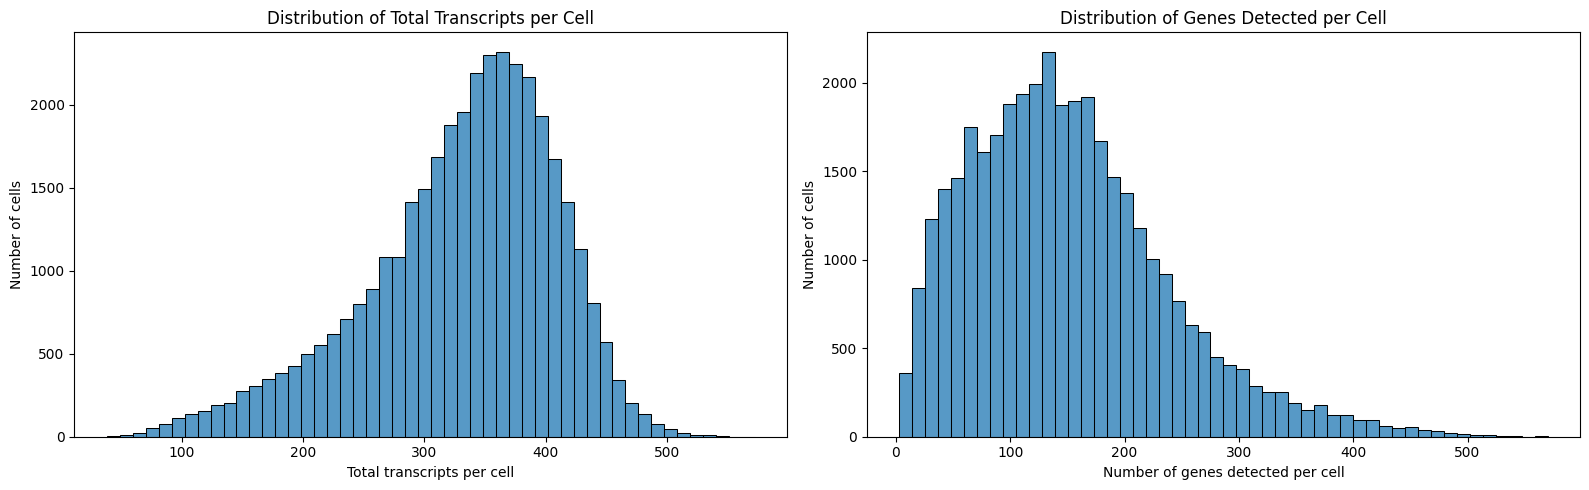

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot for total_counts
sns.histplot(adata.obs['total_counts'], bins=50, kde=False, ax=axes[0])
axes[0].set_xlabel("Total transcripts per cell")
axes[0].set_ylabel("Number of cells")
axes[0].set_title("Distribution of Total Transcripts per Cell")

# Plot for n_genes_by_counts
sns.histplot(adata.obs['n_genes_by_counts'], bins=50, kde=False, ax=axes[1])
axes[1].set_xlabel("Number of genes detected per cell")
axes[1].set_ylabel("Number of cells")
axes[1].set_title("Distribution of Genes Detected per Cell")

plt.tight_layout()
plt.show()

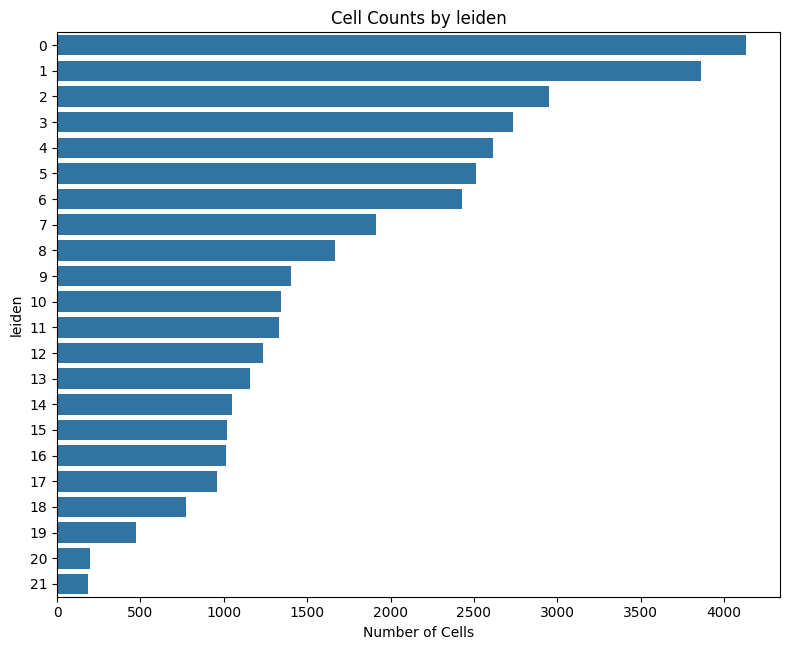

In [18]:
coll_to_summary = 'leiden'

# print(f"\n--- {coll_to_summary} ---")
# print(adata.obs[coll_to_summary].value_counts(dropna=False))

if adata.obs[coll_to_summary].nunique() < 30 and adata.obs[coll_to_summary].nunique() > 1:
    plt.figure(figsize=(8, max(4, adata.obs[coll_to_summary].nunique() * 0.3)))
    sns.countplot(y=adata.obs[coll_to_summary], order = adata.obs[coll_to_summary].value_counts(dropna=False).index)
    plt.title(f"Cell Counts by {coll_to_summary}")
    plt.xlabel("Number of Cells")
    plt.ylabel(coll_to_summary)
    plt.tight_layout()
    plt.show()

## 3. Visualization

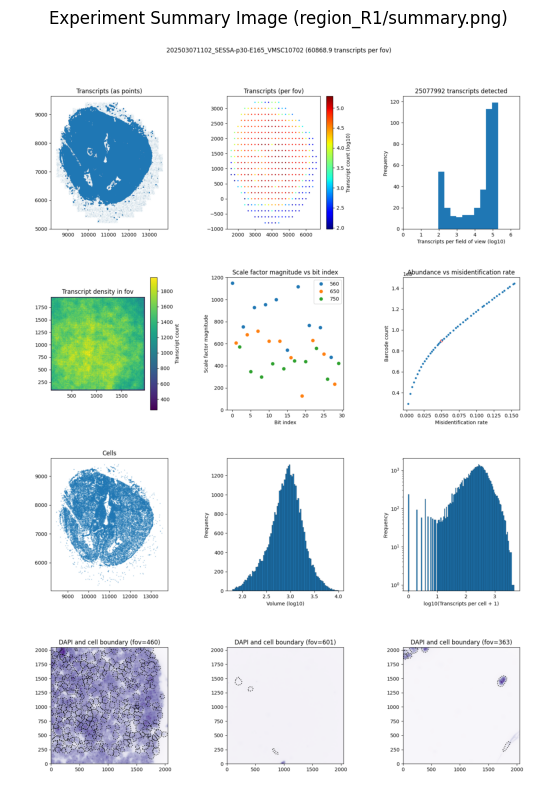

In [19]:
img = mpimg.imread(summary_image_file)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off') # Turn off axis numbers and ticks
plt.title("Experiment Summary Image (region_R1/summary.png)")
plt.show()

In [20]:
print(adata.obsm_keys())
print(list(adata.obs.columns))

['X_pca', 'X_umap']
['volume', 'center_x', 'center_y', 'n_counts', 'n_genes', 'leiden', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes']


In [21]:
adata.obsm['spatial'] = adata.obs[['center_x', 'center_y']].to_numpy()
spatial_coords_available = True

<Figure size 1000x1000 with 0 Axes>

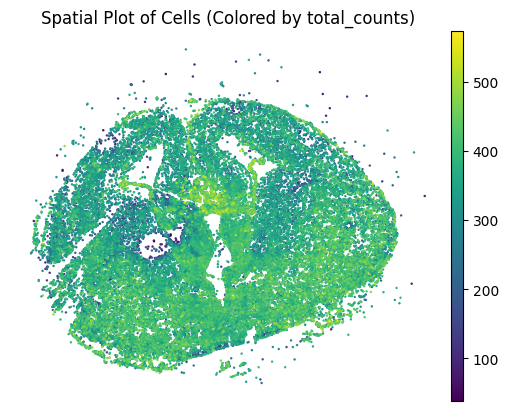

<Figure size 1000x1000 with 0 Axes>

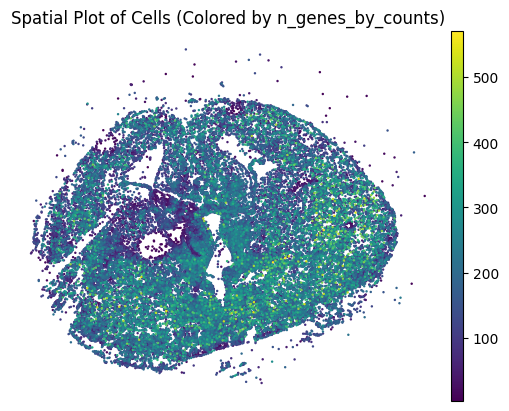

<Figure size 1000x1000 with 0 Axes>

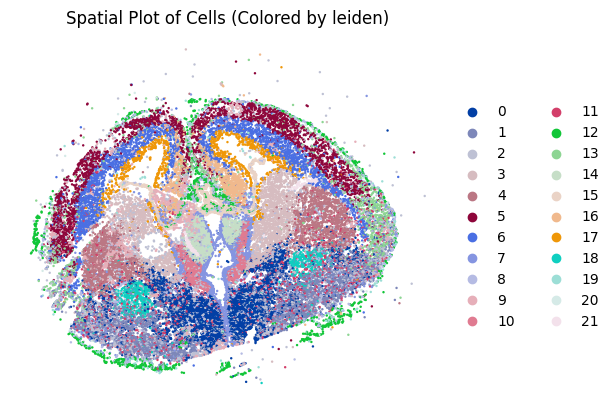

In [22]:
features = ['total_counts', 'n_genes_by_counts', 'leiden']
for color_by in features:
    plt.figure(figsize=(10, 10))
    sc.pl.spatial(adata, color=color_by, spot_size=30, show=False, frameon=False)
    plt.title(f"Spatial Plot of Cells (Colored by {color_by if color_by else 'default'})")
    plt.show()

In [23]:
print(list(adata.var.columns))
print(list(adata.uns))

['mean', 'std', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts']
['leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'cell_boundaries_gdf', 'leiden_colors']


In [24]:
# Check the log1p metadata to understand the issue
print("Checking adata.uns['log1p'] contents:")
if 'log1p' in adata.uns_keys():
    print(adata.uns['log1p'])
    print(f"Keys in log1p: {list(adata.uns['log1p'].keys())}")
else:
    print("No log1p key found in adata.uns")

Checking adata.uns['log1p'] contents:
{}
Keys in log1p: []


In [25]:
# Fix the log1p metadata issue by adding the missing 'base' key or using a workaround
if 'log1p' in adata.uns_keys() and 'base' not in adata.uns['log1p']:
    print("Adding missing 'base' key to log1p metadata...")
    # Set base to None (natural log) which is the default for scanpy
    adata.uns['log1p']['base'] = None
    print("Fixed log1p metadata:", adata.uns['log1p'])

# Alternative approach: use flavor='cell_ranger' which doesn't require log1p metadata
print("Computing highly variable genes with cell_ranger flavor to avoid log1p issues...")
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, flavor='cell_ranger')

Adding missing 'base' key to log1p metadata...
Fixed log1p metadata: {'base': None}
Computing highly variable genes with cell_ranger flavor to avoid log1p issues...


In [26]:
import numpy as np
import scipy.sparse

print(f"adata.X data type: {adata.X.dtype}")

if scipy.sparse.issparse(adata.X):
    print(adata.X[:5, :5].toarray())
    if adata.X.nnz > 0: # nnz is number of stored_elements
        print(f"Min non-zero value in adata.X: {adata.X.data.min()}")
        print(f"Max non-zero value in adata.X: {adata.X.data.max()}")
        has_nan_sparse = np.isnan(adata.X.data).any()
        has_inf_sparse = np.isinf(adata.X.data).any()
        print(f"adata.X.data contains NaNs: {has_nan_sparse}")
        print(f"adata.X.data contains Infs: {has_inf_sparse}")

else: # Dense array
    print(adata.X[:5, :5])
    print(f"Min value in adata.X: {adata.X.min()}")
    print(f"Max value in adata.X: {adata.X.max()}")
    has_nan_dense = np.isnan(adata.X).any()
    has_inf_dense = np.isinf(adata.X).any()
    print(f"adata.X contains NaNs: {has_nan_dense}")
    print(f"adata.X contains Infs: {has_inf_dense}")

adata.X data type: float32
[[0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.       ]
 [2.8870394 0.        0.        1.1319195 0.       ]]
Min value in adata.X: 0.0
Max value in adata.X: 70.20661926269531
adata.X contains NaNs: False
adata.X contains Infs: False


Plotting spatial expression for HVGs: ['Itgb2', 'Cdh4', 'Plin2']


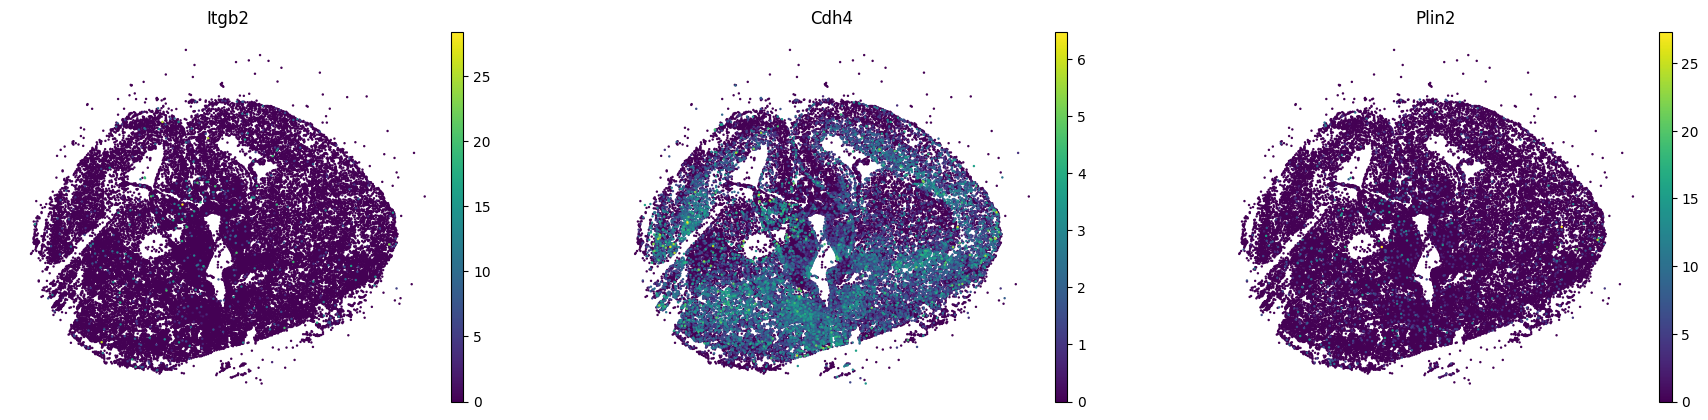

In [27]:
hvg_genes = adata.var_names[adata.var['highly_variable']].tolist()
if len(hvg_genes) > 0:
    num_genes_to_plot = min(len(hvg_genes), 3)
    genes_to_plot = hvg_genes[:num_genes_to_plot]
    print(f"Plotting spatial expression for HVGs: {genes_to_plot}")
    sc.pl.spatial(adata, color=genes_to_plot, spot_size=30, show=True, frameon=False, ncols=num_genes_to_plot)
else:
    print("No highly variable genes found after computation.")

